# align data

In [1]:
import pystac
items= pystac.ItemCollection.from_file("rhodes_sentinel-2.json")

In [2]:
item = items[0]

In [3]:
visual_href = item.assets['visual'].href

In [4]:
import rioxarray
visual = rioxarray.open_rasterio(visual_href, overview_level=1)

In [5]:
visual

<xarray.DataArray (band: 3, y: 2745, x: 2745)>
[22605075 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.1e+06 4.1e+06 4.1e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [6]:
import geopandas as gpd

In [7]:
assets = gpd.read_file('assets.gpkg')

## Crop by bounding box

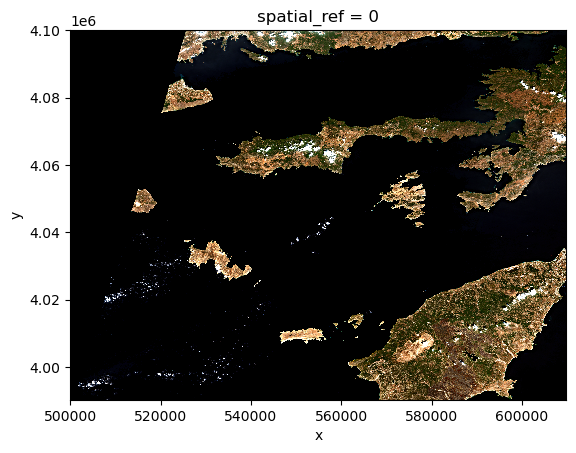

In [8]:
visual.plot.imshow()

In [9]:
assets.total_bounds

array([27.7121001 , 35.87837949, 28.24591124, 36.45725024])

In [10]:
assets = assets.to_crs(visual.rio.crs)

In [11]:
assets.total_bounds # minx, miny, maxx, maxy

array([ 564058.0257114 , 3970719.4080227 ,  611743.71498815,
       4035358.56340039])

In [12]:
visual.rio.clip_box?

Signature:
visual.rio.clip_box(
    minx: float,
    miny: float,
    maxx: float,
    maxy: float,
    auto_expand: Union[bool, int] = False,
    auto_expand_limit: int = 3,
    crs: Optional[Any] = None,
) -> xarray.core.dataarray.DataArray
Docstring:
Clip the :obj:`xarray.DataArray` by a bounding box.

.. versionadded:: 0.12 crs

Parameters
----------
minx: float
    Minimum bound for x coordinate.
miny: float
    Minimum bound for y coordinate.
maxx: float
    Maximum bound for x coordinate.
maxy: float
    Maximum bound for y coordinate.
auto_expand: Union[bool, int]
    If True, it will expand clip search if only 1D raster found with clip.
auto_expand_limit: int
    maximum number of times the clip will be retried before raising
    an exception.
crs: :obj:`rasterio.crs.CRS`, optional
    The CRS of the bounding box. Default is to assume it is the same
    as the dataset.

Returns
-------
xarray.DataArray:
    The clipped object.
File:      ~/miniconda3/envs/geospatial/lib/python

In [13]:
visual_clipbox = visual.rio.clip_box(*assets.total_bounds)

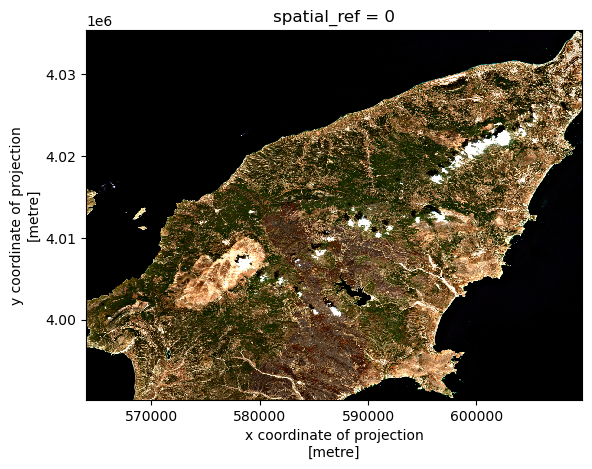

In [14]:
visual_clipbox.plot.imshow()

## Crop image with vector

In [15]:
visual_clip = visual_clipbox.rio.clip(assets["geometry"])

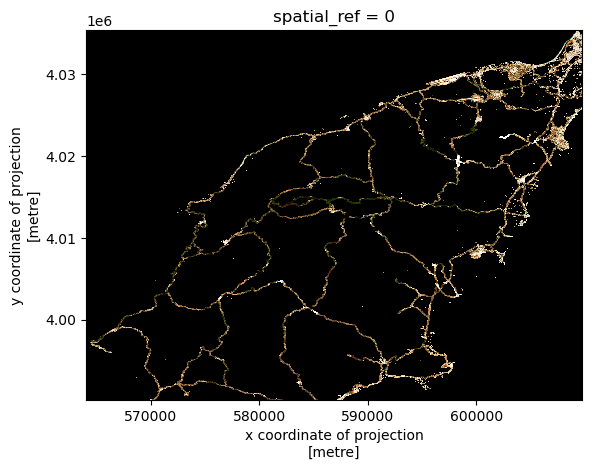

In [20]:
visual_clip.plot.imshow()

## Match two rasters

In [17]:
# loading dem file
dem = rioxarray.open_rasterio('./data/dem/rhodes.tif')

In [18]:
dem

<xarray.DataArray (band: 1, y: 2098, x: 2029)>
[4256842 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 27.68 27.68 27.68 27.68 ... 28.25 28.25 28.25 28.25
  * y            (y) float64 36.46 36.46 36.46 36.46 ... 35.88 35.88 35.88 35.88
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
dem.rio.crs

CRS.from_epsg(4326)

In [21]:
visual_clip.rio.crs

CRS.from_epsg(32635)

In [22]:
dem.rio.reproject_match?

Signature:
dem.rio.reproject_match(
    match_data_array: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset],
    resampling: rasterio.enums.Resampling = <Resampling.nearest: 0>,
    **reproject_kwargs,
) -> xarray.core.dataarray.DataArray
Docstring:
Reproject a DataArray object to match the resolution, projection,
and region of another DataArray.

Powered by :func:`rasterio.warp.reproject`

.. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
    Requires either a grid mapping variable with 'spatial_ref' or
    a 'crs' attribute to be set containing a valid CRS.
    If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

.. versionadded:: 0.9 reproject_kwargs

Parameters
----------
match_data_array:  :obj:`xarray.DataArray` | :obj:`xarray.Dataset`
    DataArray of the target resolution and projection.
resampling: rasterio.enums.Resampling, optional
    See :func:`rasterio.warp.reproject` for more details.
**reproject_kwargs

In [23]:
dem_matched = dem.rio.reproject_match(visual_clip)

In [24]:
dem_matched

<xarray.DataArray (band: 1, y: 1128, x: 1143)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 5.641e+05 5.641e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [25]:
dem_matched.rio.to_raster('dem_rhodes_match.tif', driver='COG')

In [26]:
dem_matched.rio.crs

CRS.from_epsg(32635)